In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_VGG_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', 
                      input_shape=input_shape))
    model.add(Activation('tanh'))
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same'))
    model.add(Activation('tanh'))
#     model.add(MaxPooling1D(pool_size=3, strides=3))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(Activation('tanh'))
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(Activation('tanh'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.25))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_VGG_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
activation_1 (Activation)    (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
activation_20 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_21 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_22 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_44 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
activation_72 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_74 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 16000, 64)         12352     
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9525 - acc: 0.3804
Epoch 00001: val_loss improved from inf to 1.61049, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_3_conv_checkpoint/001-1.6105.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 1.9525 - acc: 0.3804 - val_loss: 1.6105 - val_acc: 0.4994
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3818 - acc: 0.5714
Epoch 00002: val_loss improved from 1.61049 to 1.53026, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_3_conv_checkpoint/002-1.5303.hdf5
36805/36805 [==============================] - 82s 2ms/sample - loss: 1.3819 - acc: 0.5714 - val_loss: 1.5303 - val_acc: 0.5225
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1153 - acc: 0.6592
Epoch 00003: val_loss improved from 1

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0314 - acc: 0.9962
Epoch 00029: val_loss did not improve from 1.50362
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.0314 - acc: 0.9963 - val_loss: 2.4395 - val_acc: 0.5949
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0285 - acc: 0.9965
Epoch 00030: val_loss did not improve from 1.50362
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.0285 - acc: 0.9965 - val_loss: 2.3643 - val_acc: 0.6049
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0349 - acc: 0.9948
Epoch 00031: val_loss did not improve from 1.50362
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.0349 - acc: 0.9948 - val_loss: 2.5109 - val_acc: 0.5924
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0361 - acc: 0.9940
Epoch 00032: val_loss did not improve from 1.50362
36805/36805 [===========

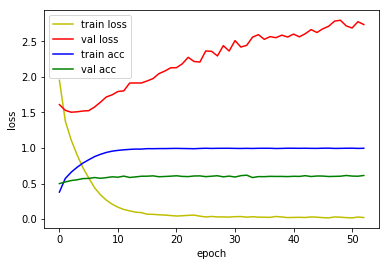

4815/4815 [==============================] - 4s 894us/sample - loss: 1.5551 - acc: 0.5157
Loss: 1.5551137644182484 Accuracy: 0.5156802

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7663 - acc: 0.4368
Epoch 00001: val_loss improved from inf to 1.36412, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_4_conv_checkpoint/001-1.3641.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 1.7663 - acc: 0.4369 - val_loss: 1.3641 - val_acc: 0.5770
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2532 - acc: 0.6173
Epoch 00002: val_loss improved from 1.36412 to 1.23164, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_4_conv_checkpoint/002-1.2316.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 1.2532 - acc: 0.6173 - val_loss: 1.2316 - val_acc: 0.6259
Epoch 3/500
36800/36805 [====================

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0637 - acc: 0.9911
Epoch 00028: val_loss did not improve from 1.08216
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0637 - acc: 0.9911 - val_loss: 1.3821 - val_acc: 0.7035
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0591 - acc: 0.9915
Epoch 00029: val_loss did not improve from 1.08216
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0591 - acc: 0.9915 - val_loss: 1.4133 - val_acc: 0.7002
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0564 - acc: 0.9926
Epoch 00030: val_loss did not improve from 1.08216
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0564 - acc: 0.9926 - val_loss: 1.3945 - val_acc: 0.7025
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0525 - acc: 0.9926
Epoch 00031: val_loss did not improve from 1.08216
36805/36805 [===========

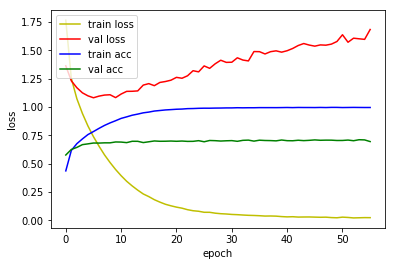

4815/4815 [==============================] - 4s 919us/sample - loss: 1.1546 - acc: 0.6474
Loss: 1.1546156158328427 Accuracy: 0.64735204

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7738 - acc: 0.4355
Epoch 00001: val_loss improved from inf to 1.42911, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_5_conv_checkpoint/001-1.4291.hdf5
36805/36805 [==============================] - 92s 2ms/sample - loss: 1.7737 - acc: 0.4356 - val_loss: 1.4291 - val_acc: 0.5481
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3414 - acc: 0.5910
Epoch 00002: val_loss improved from 1.42911 to 1.20719, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_5_conv_checkpoint/002-1.2072.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 1.3413 - acc: 0.5910 - val_loss: 1.2072 - val_acc: 0.6294
Epoch 3/500
36800/36805 [===================

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1383 - acc: 0.9702
Epoch 00026: val_loss did not improve from 0.76764
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1382 - acc: 0.9702 - val_loss: 0.8636 - val_acc: 0.7738
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1276 - acc: 0.9739
Epoch 00027: val_loss did not improve from 0.76764
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1275 - acc: 0.9739 - val_loss: 0.8795 - val_acc: 0.7780
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1203 - acc: 0.9769
Epoch 00028: val_loss did not improve from 0.76764
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1204 - acc: 0.9769 - val_loss: 0.8712 - val_acc: 0.7824
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1077 - acc: 0.9792
Epoch 00029: val_loss did not improve from 0.76764
36805/36805 [===========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0301 - acc: 0.9953
Epoch 00056: val_loss did not improve from 0.76764
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0301 - acc: 0.9953 - val_loss: 1.1303 - val_acc: 0.7710
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0296 - acc: 0.9955
Epoch 00057: val_loss did not improve from 0.76764
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0296 - acc: 0.9955 - val_loss: 1.0929 - val_acc: 0.7838
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0287 - acc: 0.9960
Epoch 00058: val_loss did not improve from 0.76764
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0287 - acc: 0.9960 - val_loss: 1.0761 - val_acc: 0.7831
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0327 - acc: 0.9942
Epoch 00059: val_loss did not improve from 0.76764
36805/36805 [===========

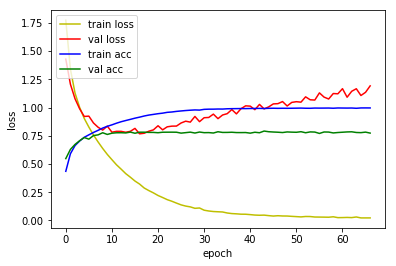

4815/4815 [==============================] - 5s 977us/sample - loss: 0.8536 - acc: 0.7564
Loss: 0.853619275348085 Accuracy: 0.7563863

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7897 - acc: 0.4245
Epoch 00001: val_loss improved from inf to 1.38553, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_6_conv_checkpoint/001-1.3855.hdf5
36805/36805 [==============================] - 95s 3ms/sample - loss: 1.7896 - acc: 0.4246 - val_loss: 1.3855 - val_acc: 0.5805
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3461 - acc: 0.5902
Epoch 00002: val_loss improved from 1.38553 to 1.17599, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_6_conv_checkpoint/002-1.1760.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.3461 - acc: 0.5901 - val_loss: 1.1760 - val_acc: 0.6424
Epoch 3/500
36800/36805 [=====================

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3744 - acc: 0.8918
Epoch 00023: val_loss improved from 0.49382 to 0.48042, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_6_conv_checkpoint/023-0.4804.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.3746 - acc: 0.8917 - val_loss: 0.4804 - val_acc: 0.8663
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3669 - acc: 0.8940
Epoch 00024: val_loss did not improve from 0.48042
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.3670 - acc: 0.8940 - val_loss: 0.4820 - val_acc: 0.8588
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3459 - acc: 0.9021
Epoch 00025: val_loss improved from 0.48042 to 0.45443, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_6_conv_checkpoint/025-0.4544.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.3459

36800/36805 [============================>.] - ETA: 0s - loss: 0.1434 - acc: 0.9601
Epoch 00050: val_loss did not improve from 0.42533
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1436 - acc: 0.9601 - val_loss: 0.4475 - val_acc: 0.8817
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1410 - acc: 0.9592
Epoch 00051: val_loss did not improve from 0.42533
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1410 - acc: 0.9592 - val_loss: 0.4371 - val_acc: 0.8831
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1353 - acc: 0.9615
Epoch 00052: val_loss did not improve from 0.42533
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1352 - acc: 0.9615 - val_loss: 0.4664 - val_acc: 0.8814
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1342 - acc: 0.9620
Epoch 00053: val_loss did not improve from 0.42533
36805/36805 [========================

Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0702 - acc: 0.9820
Epoch 00079: val_loss did not improve from 0.42397
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0702 - acc: 0.9820 - val_loss: 0.4687 - val_acc: 0.8875
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0613 - acc: 0.9842
Epoch 00080: val_loss did not improve from 0.42397
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0613 - acc: 0.9842 - val_loss: 0.4773 - val_acc: 0.8910
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0556 - acc: 0.9863
Epoch 00081: val_loss did not improve from 0.42397
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0556 - acc: 0.9863 - val_loss: 0.4644 - val_acc: 0.8928
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0555 - acc: 0.9865
Epoch 00082: val_loss did not improve from 0.42397
36805/36805 [===========

Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0326 - acc: 0.9923
Epoch 00109: val_loss did not improve from 0.42397
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0326 - acc: 0.9923 - val_loss: 0.5154 - val_acc: 0.8912
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0408 - acc: 0.9897
Epoch 00110: val_loss did not improve from 0.42397
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0408 - acc: 0.9897 - val_loss: 0.5283 - val_acc: 0.8880
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0331 - acc: 0.9924
Epoch 00111: val_loss did not improve from 0.42397
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0331 - acc: 0.9924 - val_loss: 0.4970 - val_acc: 0.8926
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0324 - acc: 0.9928
Epoch 00112: val_loss did not improve from 0.42397
36805/36805 [=======

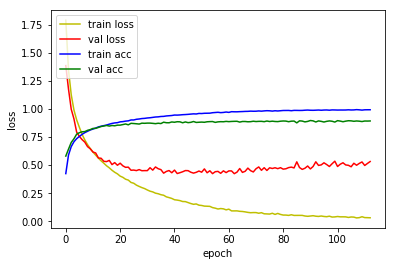

4815/4815 [==============================] - 5s 985us/sample - loss: 0.5095 - acc: 0.8677
Loss: 0.5095143529237369 Accuracy: 0.8677051

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8417 - acc: 0.4108
Epoch 00001: val_loss improved from inf to 1.43938, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_7_conv_checkpoint/001-1.4394.hdf5
36805/36805 [==============================] - 98s 3ms/sample - loss: 1.8417 - acc: 0.4108 - val_loss: 1.4394 - val_acc: 0.5535
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4147 - acc: 0.5600
Epoch 00002: val_loss improved from 1.43938 to 1.20139, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_7_conv_checkpoint/002-1.2014.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 1.4146 - acc: 0.5600 - val_loss: 1.2014 - val_acc: 0.6504
Epoch 3/500
36800/36805 [====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.2821 - acc: 0.9183
Epoch 00022: val_loss improved from 0.29971 to 0.29939, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_7_conv_checkpoint/022-0.2994.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.2820 - acc: 0.9183 - val_loss: 0.2994 - val_acc: 0.9122
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2713 - acc: 0.9226
Epoch 00023: val_loss improved from 0.29939 to 0.28552, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_7_conv_checkpoint/023-0.2855.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.2714 - acc: 0.9225 - val_loss: 0.2855 - val_acc: 0.9180
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2654 - acc: 0.9244
Epoch 00024: val_loss improved from 0.28552 to 0.27229, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_7_conv_chec

36800/36805 [============================>.] - ETA: 0s - loss: 0.1196 - acc: 0.9646
Epoch 00048: val_loss did not improve from 0.21827
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1195 - acc: 0.9646 - val_loss: 0.2341 - val_acc: 0.9390
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1138 - acc: 0.9670
Epoch 00049: val_loss did not improve from 0.21827
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1138 - acc: 0.9670 - val_loss: 0.2219 - val_acc: 0.9406
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1133 - acc: 0.9678
Epoch 00050: val_loss improved from 0.21827 to 0.19611, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_7_conv_checkpoint/050-0.1961.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1133 - acc: 0.9678 - val_loss: 0.1961 - val_acc: 0.9464
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - los

Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0510 - acc: 0.9860
Epoch 00077: val_loss did not improve from 0.19454
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0510 - acc: 0.9860 - val_loss: 0.2248 - val_acc: 0.9427
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0476 - acc: 0.9863
Epoch 00078: val_loss did not improve from 0.19454
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0476 - acc: 0.9863 - val_loss: 0.2316 - val_acc: 0.9436
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0479 - acc: 0.9872
Epoch 00079: val_loss did not improve from 0.19454
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0479 - acc: 0.9872 - val_loss: 0.2178 - val_acc: 0.9464
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0416 - acc: 0.9893
Epoch 00080: val_loss did not improve from 0.19454
36805/36805 [===========

Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0221 - acc: 0.9947
Epoch 00107: val_loss did not improve from 0.19454
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0221 - acc: 0.9947 - val_loss: 0.2710 - val_acc: 0.9413
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0320 - acc: 0.9912
Epoch 00108: val_loss did not improve from 0.19454
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0320 - acc: 0.9912 - val_loss: 0.2508 - val_acc: 0.9425
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0214 - acc: 0.9945
Epoch 00109: val_loss did not improve from 0.19454
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0214 - acc: 0.9945 - val_loss: 0.2349 - val_acc: 0.9467
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0215 - acc: 0.9944
Epoch 00110: val_loss did not improve from 0.19454
36805/36805 [=======

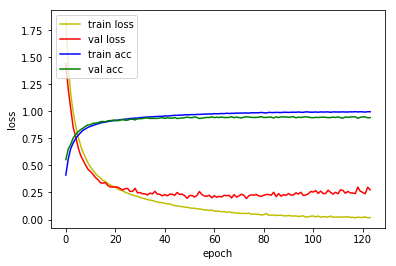

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2530 - acc: 0.9277
Loss: 0.2529973657084155 Accuracy: 0.92772585

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8411 - acc: 0.4154
Epoch 00001: val_loss improved from inf to 1.34986, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_8_conv_checkpoint/001-1.3499.hdf5
36805/36805 [==============================] - 102s 3ms/sample - loss: 1.8411 - acc: 0.4154 - val_loss: 1.3499 - val_acc: 0.6028
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2672 - acc: 0.6083
Epoch 00002: val_loss improved from 1.34986 to 0.99530, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_8_conv_checkpoint/002-0.9953.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 1.2671 - acc: 0.6084 - val_loss: 0.9953 - val_acc: 0.7177
Epoch 3/500
36800/36805 [====================

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1514 - acc: 0.9550
Epoch 00023: val_loss improved from 0.15984 to 0.15003, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_8_conv_checkpoint/023-0.1500.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1514 - acc: 0.9550 - val_loss: 0.1500 - val_acc: 0.9541
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1422 - acc: 0.9582
Epoch 00024: val_loss did not improve from 0.15003
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1422 - acc: 0.9582 - val_loss: 0.1606 - val_acc: 0.9546
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1404 - acc: 0.9571
Epoch 00025: val_loss did not improve from 0.15003
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1404 - acc: 0.9571 - val_loss: 0.1567 - val_acc: 0.9518
Epoch 26/500
36800/36805 [============================>.] - 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0462 - acc: 0.9860
Epoch 00051: val_loss did not improve from 0.13731
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0462 - acc: 0.9860 - val_loss: 0.1558 - val_acc: 0.9590
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0485 - acc: 0.9854
Epoch 00052: val_loss did not improve from 0.13731
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0485 - acc: 0.9854 - val_loss: 0.1621 - val_acc: 0.9550
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0433 - acc: 0.9873
Epoch 00053: val_loss did not improve from 0.13731
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0433 - acc: 0.9873 - val_loss: 0.1404 - val_acc: 0.9639
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0415 - acc: 0.9885
Epoch 00054: val_loss did not improve from 0.13731
36805/36805 [========================

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0161 - acc: 0.9958
Epoch 00081: val_loss did not improve from 0.13731
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0161 - acc: 0.9958 - val_loss: 0.1706 - val_acc: 0.9637
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0189 - acc: 0.9950
Epoch 00082: val_loss did not improve from 0.13731
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0189 - acc: 0.9950 - val_loss: 0.1651 - val_acc: 0.9651
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0171 - acc: 0.9956
Epoch 00083: val_loss did not improve from 0.13731
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0171 - acc: 0.9956 - val_loss: 0.1642 - val_acc: 0.9620
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0125 - acc: 0.9967
Epoch 00084: val_loss did not improve from 0.13731
36805/36805 [===========

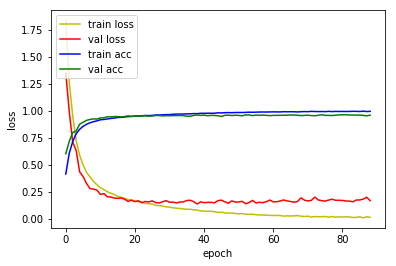

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1670 - acc: 0.9487
Loss: 0.166974950755868 Accuracy: 0.948702

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4279 - acc: 0.5553
Epoch 00001: val_loss improved from inf to 0.82447, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_9_conv_checkpoint/001-0.8245.hdf5
36805/36805 [==============================] - 106s 3ms/sample - loss: 1.4278 - acc: 0.5553 - val_loss: 0.8245 - val_acc: 0.7503
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7520 - acc: 0.7740
Epoch 00002: val_loss improved from 0.82447 to 0.50486, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_9_conv_checkpoint/002-0.5049.hdf5
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.7519 - acc: 0.7740 - val_loss: 0.5049 - val_acc: 0.8488
Epoch 3/500
36800/36805 [=======================

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0597 - acc: 0.9820
Epoch 00025: val_loss did not improve from 0.12072
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0597 - acc: 0.9820 - val_loss: 0.1364 - val_acc: 0.9595
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0562 - acc: 0.9828
Epoch 00026: val_loss did not improve from 0.12072
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0562 - acc: 0.9828 - val_loss: 0.1345 - val_acc: 0.9590
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0536 - acc: 0.9839
Epoch 00027: val_loss did not improve from 0.12072
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0536 - acc: 0.9839 - val_loss: 0.1346 - val_acc: 0.9627
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0501 - acc: 0.9855
Epoch 00028: val_loss did not improve from 0.12072
36805/36805 [===========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0130 - acc: 0.9965
Epoch 00055: val_loss did not improve from 0.12072
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0130 - acc: 0.9965 - val_loss: 0.1473 - val_acc: 0.9644
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0095 - acc: 0.9974
Epoch 00056: val_loss did not improve from 0.12072
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0095 - acc: 0.9974 - val_loss: 0.1562 - val_acc: 0.9637
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0088 - acc: 0.9978
Epoch 00057: val_loss did not improve from 0.12072
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0088 - acc: 0.9978 - val_loss: 0.1834 - val_acc: 0.9595
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0166 - acc: 0.9948
Epoch 00058: val_loss did not improve from 0.12072
36805/36805 [===========

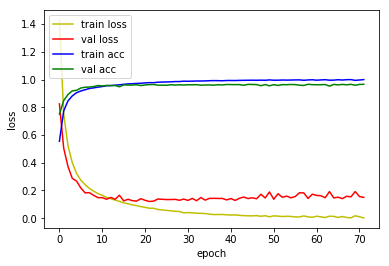

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1817 - acc: 0.9475
Loss: 0.18166653738276856 Accuracy: 0.9474559



In [10]:
for i in range(3, 10):
    base = '1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
activation_90 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_91 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_92 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_93 (Conv1D)    

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.8536 - acc: 0.7564
Loss: 0.853619275348085 Accuracy: 0.7563863

1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_114 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
activation_114 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_115 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
activation_115 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_116 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
activation_116 (Activa

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2530 - acc: 0.9277
Loss: 0.2529973657084155 Accuracy: 0.92772585

1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_140 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
activation_140 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_141 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
activation_141 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_142 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
activation_142 (Acti

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1817 - acc: 0.9475
Loss: 0.18166653738276856 Accuracy: 0.9474559


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

with open(path.join(log_dir, base+'_last'), 'w') as log_file:
    for i in range(3, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + '000_last.hdf5'

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
activation_90 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_91 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_92 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_93 (Conv1D)    

4815/4815 [==============================] - 6s 1ms/sample - loss: 1.3754 - acc: 0.7406
Loss: 1.3754152800311428 Accuracy: 0.74060225

1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_114 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
activation_114 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_115 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
activation_115 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_116 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
activation_116 (Acti

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.3292 - acc: 0.9227
Loss: 0.3291676991964426 Accuracy: 0.9227414

1D_CNN_custom_conv_3_VGG_tanh_DO_025_DO_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_140 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
activation_140 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_141 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
activation_141 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_142 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
activation_142 (Activ

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2015 - acc: 0.9566
Loss: 0.20154722960741256 Accuracy: 0.956594
